# Preliminaries

In [1]:
from TenGAN.ggan import ModelZoo

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def trim(word):
    
    w = word
    
    trim_characters = [' ']
    trim_characters = {t_c:True for t_c in trim_characters}
    
    if w[0] in trim_characters:
        return trim(w[1:])
    
    if w[-1] in trim_characters:
        return trim(w[:-1])
    
    return w

# Get Generator Params

In [4]:
config_id = 0

if config_id is not None:

    hps = dict()

    with open(f'configs.txt', 'r') as f: text = f.read()

    hp_text_lists = [[h for h in t.split('{')[-1].split('\n') if len(h) > 0 and len(h) < 100] for t in text.split('}')][:-1]
    hp_text_list = hp_text_lists[config_id]

    for hp_text in hp_text_list:

        hp_name = trim(hp_text.split(':')[0])
        hp_value = trim(hp_text.split(':')[1])

        if hp_name in ['gen_model', 'disc_model']: hp_value = str(hp_value)
        else:
            try: hp_value = eval(hp_value)
            except: hp_value = str(hp_value)

        hps[hp_name] = hp_value

    del text, hp_text_list

In [5]:
values = {
          5:(38.56541442871094),                # good
          10:(18.63817024230957),               # alright
          25:(12.40575885772705),               # alright
          50:(11.834113121032715),              # alright
          100:(10.044989585876465),             # good
          150:(10.37658405303955),              # good
          200:(8.628310203552246),              # good
          250:(7.5171709060668945),             # good
        #   300:(6.600218296051025),              # good
        #   350:(3.8305752277374268)              # good
          # 512:(5.233729839324951)
         }

In [6]:
ranks = list(values)

In [7]:
display_percent = False

num_params = list()

# exact generator parameters
if not display_percent:
    def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)

    zoo = ModelZoo()
    gen_class = zoo.get_model(hps['gen_model'])

    for rank in ranks:
        
        hps['decomp_rank'] = rank

        generator = gen_class(latent_dim = hps['latent_dim'],    # 1D noise vector input dim
                              layer_size = hps['gen_layer_size'],      # hidden_layer size
                              num_nodes = hps['num_nodes'],      # image height & width
                              rank = hps['decomp_rank'],            # tensor decomposition rank
                              num_views = hps['num_views'],       # num_channels for image
                              decomp_type = hps['tensor_model'],  # decomposition type - 'CPD', 'tucker' only so far
                              num_tensor_modes = 3,             # number of tensor_modes, exclude mode for batch size
                              tensor_decomposition = True,
                              opt = hps
                              )
        
        num_params += [count_parameters(generator) / 1e6]

# output generator parameters
else: num_params = [ 100 * ((51+51+25)*rank) / (51*51*25) for rank in ranks]
    
num_params = np.array(num_params)

# Plot

In [8]:
x = num_params
y = list(values.values())

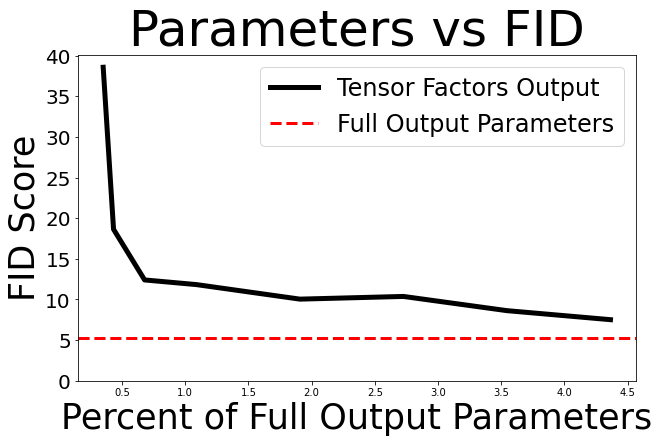

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(x, y, linewidth = 5, color = 'black', label = 'Tensor Factors Output')
plt.ylim(bottom = 0)


axis_font_size = 35
plt.xlabel('Percent of Full Output Parameters', fontsize = axis_font_size)
plt.ylabel('FID Score', fontsize = axis_font_size)
plt.title('Parameters vs FID', fontsize = 50)

tick_font_size = 20
xticks = list(range(0, 50+1, 10))
# plt.xticks(xticks, labels = [f'{xt}%' for xt in xticks], fontsize = tick_font_size)
plt.yticks(fontsize = tick_font_size)

plt.axhline(5.233729839324951, color = 'red', linestyle = '--', linewidth = 3, label = 'Full Output Parameters')

plt.legend(fontsize = 24)

plt.show()